# Computing Discrepancies in Kinetic Temperature

created 2025-08-08, by Kananovich. The code is based on the code an_benchmark, version 22.
2025-10-15 updated

2025-10-16 updated to calculate frational uncertainty as per textbook


k in range from 0 to
3
..........
0
1
2


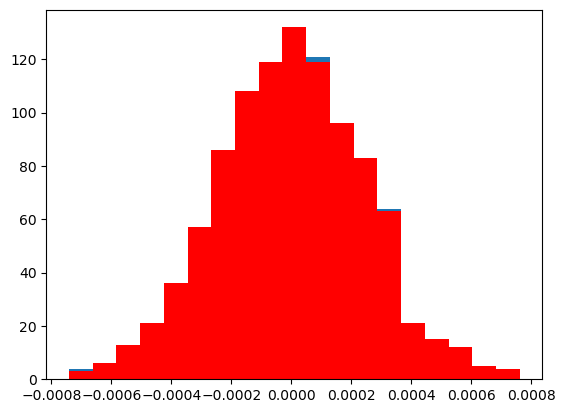

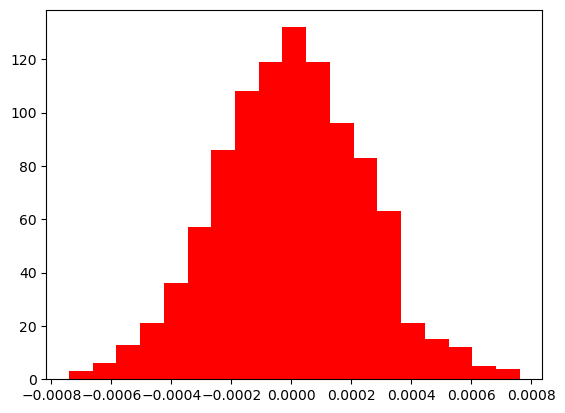

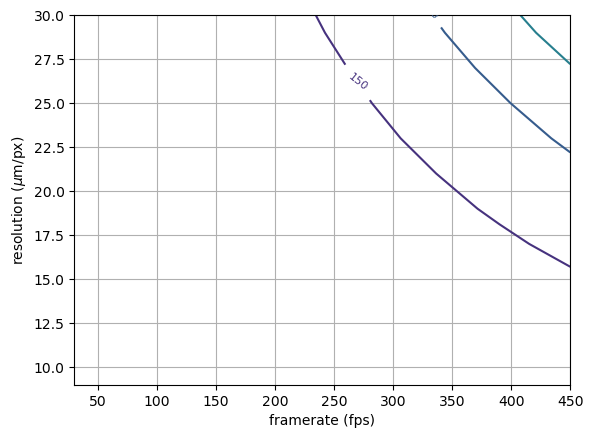

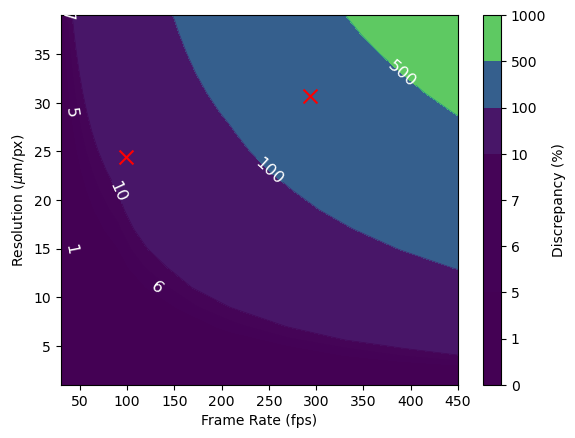

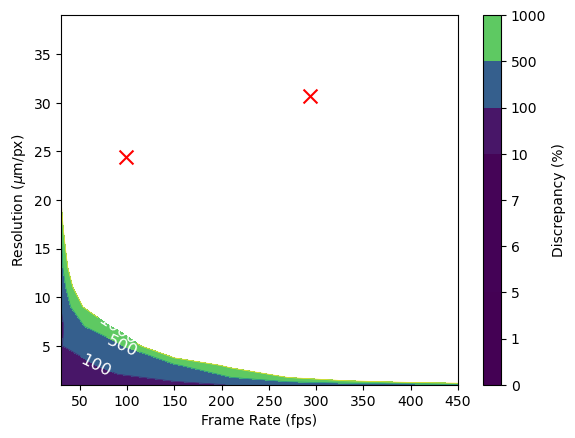

In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Computing Discrepancies in Kinetic Temperature

# created 2025-08-08, by Kananovich. The code is based on the code an_benchmark, version 22.
# 

# In[1]:


import numpy as np
import scipy.stats as sts
from scipy import constants as cnst
import pandas as pd
from matplotlib import pyplot as plt


# ### top-level data used very below:

# In[ ]:


#arr_resol = np.arange(1E-6,40E-6,2.0E-6)
#arr_framerate = np.arange(30.0, 305.0, 30.0)
#arr_discrep_average = np.zeros((len(arr_resol), len(arr_framerate)))
#number_of_averaging_iterations = 2
#levels_f_contour = np.array([0,10,40,80,160,320,1000,3000,4000,6000])
#max_lev = np.max(levels_f_contour)

#arr_resol = np.arange(1E-6,40E-6,0.4E-7) #values to run at HPC
#arr_framerate = np.arange(30.0, 506.0, 2.0) #values to run at HPC
#number_of_averaging_iterations = 100 #values to run at HPC

#arr_resol = np.arange(1E-6,40E-6,1.0E-7) #values to run at HPC FAST
#arr_framerate = np.arange(30.0, 506.0, 10.0) #values to run at HPC FAST
#number_of_averaging_iterations = 20 #values to run at HPC FAST

arr_resol = np.arange(1E-6,40E-6,2.0E-6) #values for debug
arr_framerate = np.arange(30.0, 506.0, 60) #values for debug
number_of_averaging_iterations = 3  #values for debug

arr_discrep_average = np.zeros((len(arr_resol), len(arr_framerate)))
arr_discrep_sum_of_squares = np.zeros((len(arr_resol), len(arr_framerate))) # array to hold sum of squared discrepancies

#levels_f_contour = np.array([0,10,40,80,160,320,1000,5000,10000,20000])
levels_f_contour = np.array([0,1,5,6,7,10,100,500,1000])
max_lev = np.max(levels_f_contour)


# general parameters.
# camera resolution updated on 2025-04-17 using the data provided by Parth

# In[2]:


nP = 1000 #number of particles
rho = 1510.0
dust_diam = 7.14E-6
fps = 1.0E10 # camera framerate in frames per second
#fps = 295.0 # camera framerate in frames per second
time_step = 1.0 / fps
res_meters_per_px = 30.0E-20
#res_meters_per_px = 30E-6
resol_SI = 1.0 / res_meters_per_px # camera resolution in px/meters
dust_mass = 4.0 / 3.0 * np.pi * (dust_diam / 2.0)**3 * rho #mass of the dust particles
kin_Tx = 1000.0 #kinetic temperature (in Kelvins) along the x axis
kin_Ty = 1000.0 #kinetic temperature (in Kelvins) along the y axis
drift_x = 0  # asuming the average x-component of the particles is zero (no drift)
left_x_bord = 0
right_x_bord = 1751.0 # right border of the field of view in pixels
left_x_bord_SI = left_x_bord / resol_SI
right_x_bord_SI = right_x_bord / resol_SI #coordinated of the right border
    #of the filed of view in meters


# In[3]:


resol_SI


# ## Step 1. Creating an array of artificial velocities

# In[4]:


arr_ind = np.arange(0,nP,1,dtype = 'int') # array of particles ID numbers


# In[5]:


sigma_x = np.sqrt(cnst.k * kin_Tx / dust_mass)


# In[6]:


sigma_x


# In[7]:


art_vx_rv = sts.norm(drift_x,sigma_x)
arr_sample_vx = art_vx_rv.rvs(nP)


# ## Step 2. Creating an array of artificial coordinates

# In[8]:


art_x_prev_rv = sts.uniform(left_x_bord_SI, right_x_bord_SI - left_x_bord_SI)
arr_sample_prev_x = art_x_prev_rv.rvs(nP)


# In[9]:


arr_prev_x_inResolChunks = arr_sample_prev_x * resol_SI


# In[10]:


arr_prev_x_inResolChunks_int = arr_prev_x_inResolChunks.astype(int)


# In[11]:


arr_rough_prev_x = arr_prev_x_inResolChunks_int.astype('float64') / resol_SI


# ## Step 3. Creating an array of artificial coordinates for the "next frame"

# In[12]:


arr_next_x = arr_rough_prev_x + arr_sample_vx * time_step


# In[13]:


arr_next_x_inResolChunks = arr_next_x * resol_SI
arr_next_x_inResolChunks_int = arr_next_x_inResolChunks.astype('int64')
arr_rough_next_x = arr_next_x_inResolChunks_int.astype('float64') / resol_SI


# ## Step 4. Calculating the restored velocities

# In[14]:


arr_vx_restored = (arr_rough_next_x - arr_rough_prev_x) / time_step


# ## Step 5. Calculating the array of discrepancies

# In[15]:


arr_discrep_x = np.abs(arr_vx_restored - arr_sample_vx)


# In[16]:


arr_frac_discrep_x = np.abs(arr_discrep_x / arr_sample_vx) * 100


# In[17]:


arr_frac_discrep_x.min()


# In[18]:


arr_frac_discrep_x.max()


# In[19]:


arr_frac_discrep_x.mean()


# In[20]:


def create_art_vels(tTx, tTy, N_particles, metersPerPx, frps, ro, diam, drift_x, drift_y, left_x, right_x, lefty, right_y):
    import numpy as np
    import scipy.stats as sts
    from scipy import constants as cnst
    resol_SI = 1.0 / metersPerPx # camera resolution in px/meters
   
    dust_mass = 4.0 / 3.0 * np.pi * (diam / 2.0)**3 * ro #mass of the dust particles
    sigma_x = np.sqrt(cnst.k * tTx / dust_mass)
    sigma_y = np.sqrt(cnst.k * tTy / dust_mass)
    left_x_bord_SI = left_x / resol_SI
    right_x_bord_SI = right_x / resol_SI #coordinated of the right border
    time_step = 1.0 / frps


    #Creating the arrays to store data in:
    arr_ind = np.arange(0,N_particles,1,dtype = 'int') # array of particles ID numbers
    arr_first_frame_no = np.zeros(N_particles, dtype = 'int')
    arr_first_frame_no = arr_first_frame_no + int(1)        #array to store the frist frame number
    arr_next_frame_no = np.zeros(N_particles, dtype = 'int')
    arr_next_frame_no = arr_next_frame_no + int(2)        #array to store the frist frame number

    #array to store the "nonexistent" data:

    arr_nan = np.empty(N_particles)
    arr_nan.fill(np.nan)
    
    

    artif_vx_rv = sts.norm(drift_x,sigma_x)
    arr_sample_vx = artif_vx_rv.rvs(N_particles)

    #Array of artificial coordinates for the "previous" frame:
    art_x_prev_rv = sts.uniform(left_x_bord_SI, right_x_bord_SI - left_x_bord_SI)
    arr_sample_prev_x = art_x_prev_rv.rvs(N_particles)

    arr_prev_x_inResolChunks = arr_sample_prev_x * resol_SI
    arr_prev_x_inResolChunks_int = arr_prev_x_inResolChunks.astype(int)
    arr_rough_prev_x = arr_prev_x_inResolChunks_int.astype('float64') / resol_SI
    
    ## Step 3. Creating an array of artificial coordinates for the "next frame"
    arr_next_x = arr_rough_prev_x + arr_sample_vx * time_step
    arr_next_x_inResolChunks = arr_next_x * resol_SI
    arr_next_x_inResolChunks_int = arr_next_x_inResolChunks.astype('int64')
    arr_rough_next_x = arr_next_x_inResolChunks_int.astype('float64') / resol_SI

## Step 4: Calculating the "restored" velocities:
    arr_vx_restored = (arr_rough_next_x - arr_rough_prev_x) / time_step

    #saving all the data in the output dataframe:
    
    #first, create a dataframe storing the data of the first 'video frame':
    
    dataFirstFrame = {'particle':arr_ind, 'frame':arr_first_frame_no, 'x': arr_rough_prev_x, 'vx':arr_vx_restored, 'real_vx': arr_sample_vx}
    first_df = pd.DataFrame(dataFirstFrame)
    
    #the same for the next video frame:

    dataNextFrame = {'particle':arr_ind, 'frame':arr_next_frame_no, 'x': arr_rough_next_x, 'vx':arr_nan, 'real_vx': arr_nan}
    next_df = pd.DataFrame(dataNextFrame)
    
    ret_df = pd.concat([first_df,next_df], ignore_index = True)
    return ret_df
df = create_art_vels(1200, 1200, 1000, 1.0E-8, 100, 1510, 7.14E-6, 0, 0, 0, 1751, 0, 400)
df


# In[21]:


df_first = df[df['frame'] == 1]
arr_vxTheor = np.array(df_first['real_vx'])


# In[22]:


counts_xt, bins_xt = np.histogram(arr_vxTheor, bins = 19)
fig_x, ax_x = plt.subplots()
arr_bins_centers = 0.5 * (bins_xt[1:] + bins_xt[:-1])
ax_x.bar(arr_bins_centers, counts_xt, width = (arr_bins_centers[1] - arr_bins_centers[0]))


# In[23]:


bins_x = arr_bins_centers - 0.5 * (arr_bins_centers[1] - arr_bins_centers[0])


# In[24]:


bins_x = np.append(bins_x, bins_x[-1] + (bins_x[1] - bins_x[0]))


# In[25]:


arr_vx = np.array(df_first['vx'])
counts_xe, bins_xe = np.histogram(arr_vx, bins = bins_x)
#counts_xe, bins_xe = np.histogram(arr_vx, bins = 100)


# In[26]:


bins_xe


# In[27]:


bins_xt


# In[28]:


arr_bins_e_centers = 0.5 * (bins_xe[1:] + bins_xe[:-1])


# In[29]:


ax_x.bar(arr_bins_e_centers, counts_xe, width = (arr_bins_centers[1] - arr_bins_centers[0]), color = 'red')
fig_x


# In[30]:


fig_x_e, ax_x_e = plt.subplots()
ax_x_e.bar(arr_bins_e_centers, counts_xe, width = (arr_bins_centers[1] - arr_bins_centers[0]), color = 'red')


# In[31]:


std = np.std(arr_vx)


# In[32]:


std


# In[33]:


tT = std**2 * dust_mass / cnst.k


# In[34]:


tT


# In[36]:

print("k in range from 0 to")
print(number_of_averaging_iterations)
print(r"..........")
for k in range(0, number_of_averaging_iterations):
    print(k)    
    arr_discrep = np.zeros((len(arr_resol), len(arr_framerate)))
    for j in range(0, len(arr_framerate)):
        frmrt_j = arr_framerate[j]
        for i in range(0, len(arr_resol)):
            res_i = arr_resol[i]
            df_i = create_art_vels(kin_Tx, kin_Ty, 1000, res_i, frmrt_j, 1510, 7.14E-6, 0, 0, 0, 1751, 0, 400)
            df_i_ff = df_i[df_i['frame'] == 1]
            std_i = np.std(df_i['vx'])
            tT = std_i**2 * dust_mass / cnst.k
            arr_discrep[i, j] = np.abs((kin_Tx - std_i**2 * dust_mass / cnst.k))
    arr_discrep_average = arr_discrep_average + arr_discrep / number_of_averaging_iterations
    arr_discrep_sum_of_squares = arr_discrep_sum_of_squares + arr_discrep ** 2
    


arr_STD = np.sqrt(arr_discrep_sum_of_squares / (number_of_averaging_iterations))
arr_SDOM = arr_STD / np.sqrt(number_of_averaging_iterations) # uncertainty as SDOM
arr_fracUncert = arr_SDOM / kin_Tx #calculating fractional uncertainty
    

# In[39]:


X, Y = np.meshgrid(arr_framerate, arr_resol * 1000000)


# In[40]:


fig4, ax4 = plt.subplots()
khuj = ax4.contour(X, Y, arr_fracUncert)
ax4.set_ylabel(r"resolution ($\mu$m/px)")
ax4.set_xlabel(r"framerate (fps)")
ax4.clabel(khuj,
          inline=True,       # draw labels on the contour lines
          fmt='%1.0f',       # format string for the level numbers
          fontsize=8)
ax4.grid(True)
ax4.set_ylim(9, 30)


# In[ ]:


from matplotlib import colors
# Assuming X, Y, arr_discrep_average are already defined
fig4, ax4 = plt.subplots()

# Filled contours
khuj = ax4.contourf(X, Y, arr_fracUncert, levels= levels_f_contour, norm=colors.Normalize(vmin=0, vmax=max_lev))

# Add colorbar with customized ticks
cbar = plt.colorbar(khuj, ax=ax4, label='Discrepancy (%)')

# Axis labels
ax4.set_ylabel(r"Resolution ($\mu$m/px)")
ax4.set_xlabel(r"Frame Rate (fps)")

# Experimental points
ax4.scatter([99, 294], [24.39, 30.69], marker='x', color='red', label='Experimental points', s=100)

# Set colorbar limits to enforce end at 400
#cbar.ax.set_ylim(0, 400)

line_contours = ax4.contour(X, Y, arr_fracUncert, levels=khuj.levels, linewidths=0.5,norm=colors.Normalize(vmin=0, vmax=max_lev))

ax4.clabel(
    line_contours,
    # khuj,
    fmt='%1.0f',
    fontsize=12,
    colors='white',
    inline=True,
    inline_spacing=2,
)
#plt.savefig(f'Discrepancy_{TeV}eV.png', bbox_inches='tight')
#plt.tight_layout()
#plt.show()


# In[45]:


khuj.levels


# In[51]:


fig4.savefig("contour_fac_uncert.png")


# In[52]:


fig4.savefig("contour_frac_uncert.eps")


# In[ ]:






# In[3]:


df = pd.DataFrame(
        arr_discrep_average,
        index=pd.Index(arr_resol, name="resolution"),
        columns=pd.Index(arr_framerate, name="frame_rate"))


# In[5]:


df.to_csv("ptv_results.csv", float_format="%.9e")


# In[6]:


df = pd.read_csv("ptv_results.csv", index_col=0)
frame_rates = df.columns.astype(float).to_numpy()
resolutions = df.index.to_numpy()
Z = df.to_numpy()


# In[9]:


Xf, Yf = np.meshgrid(frame_rates, resolutions * 1000000)


# In[40]:


# Assuming X, Y, arr_discrep_average are already defined
fig5, ax5 = plt.subplots()

# Filled contours
khuj5 = ax5.contourf(Xf, Yf, Z, levels= levels_f_contour, norm=colors.Normalize(vmin=0, vmax=max_lev))

# Add colorbar with customized ticks
cbar5 = plt.colorbar(khuj5, ax=ax5, label='Discrepancy (%)')

# Axis labels
ax5.set_ylabel(r"Resolution ($\mu$m/px)")
ax5.set_xlabel(r"Frame Rate (fps)")

# Experimental points
ax5.scatter([99, 294], [24.39, 30.69], marker='x', color='red', label='Experimental points', s=100)

# Set colorbar limits to enforce end at 400
#cbar.ax.set_ylim(0, 400)

line_contours5 = ax5.contour(Xf, Yf, Z, levels=khuj.levels, linewidths=0.5,norm=colors.Normalize(vmin=0, vmax=max_lev))

ax5.clabel(
    line_contours5,
    # khuj,
    fmt='%1.0f',
    fontsize=12,
    colors='white',
    inline=True,
    inline_spacing=2,
)


# In[8]:


fig4


# In[ ]:


fig5.savefig("contour_discrepancy_restored.png")


# In[52]:


fig4.savefig("contour_discrepancy_restored.eps")



In [2]:
df = pd.DataFrame(
        arr_fracUncert,
        index=pd.Index(arr_resol, name="resolution"),
        columns=pd.Index(arr_framerate, name="frame_rate"))

In [3]:
df.to_csv("ptv_results.csv", float_format="%.9e")

In [4]:
df = pd.read_csv("ptv_results.csv", index_col=0)
frame_rates = df.columns.astype(float).to_numpy()
resolutions = df.index.to_numpy()
Z = df.to_numpy()

<a list of 7 text.Text objects>

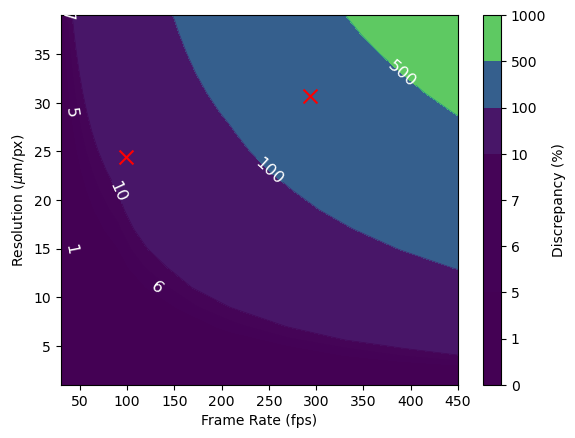

In [5]:
Xf, Yf = np.meshgrid(frame_rates, resolutions * 1000000)


# In[40]:


# Assuming X, Y, arr_discrep_average are already defined
fig5, ax5 = plt.subplots()

# Filled contours
khuj5 = ax5.contourf(Xf, Yf, Z, levels= levels_f_contour, norm=colors.Normalize(vmin=0, vmax=max_lev))

# Add colorbar with customized ticks
cbar5 = plt.colorbar(khuj5, ax=ax5, label='Discrepancy (%)')

# Axis labels
ax5.set_ylabel(r"Resolution ($\mu$m/px)")
ax5.set_xlabel(r"Frame Rate (fps)")

# Experimental points
ax5.scatter([99, 294], [24.39, 30.69], marker='x', color='red', label='Experimental points', s=100)

# Set colorbar limits to enforce end at 400
#cbar.ax.set_ylim(0, 400)

line_contours5 = ax5.contour(Xf, Yf, Z, levels=khuj.levels, linewidths=0.5,norm=colors.Normalize(vmin=0, vmax=max_lev))

ax5.clabel(
    line_contours5,
    # khuj,
    fmt='%1.0f',
    fontsize=12,
    colors='white',
    inline=True,
    inline_spacing=2,
)

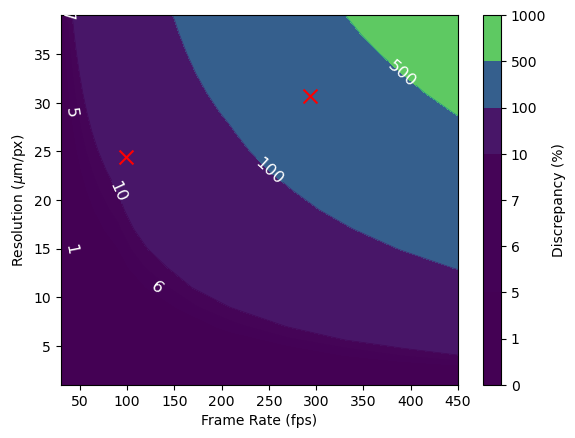

In [6]:
fig4

In [7]:
fig5.savefig("contour_frac_uncert_restored.png")


# In[52]:


fig4.savefig("contour_frac_uncert_restored.eps")

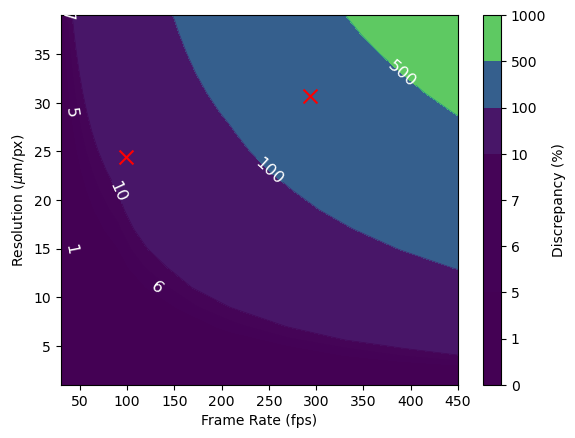

In [8]:
fig4